In [2]:
!pip install qrcode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 6.9 MB/s eta 0:00:00


Please enter：hi


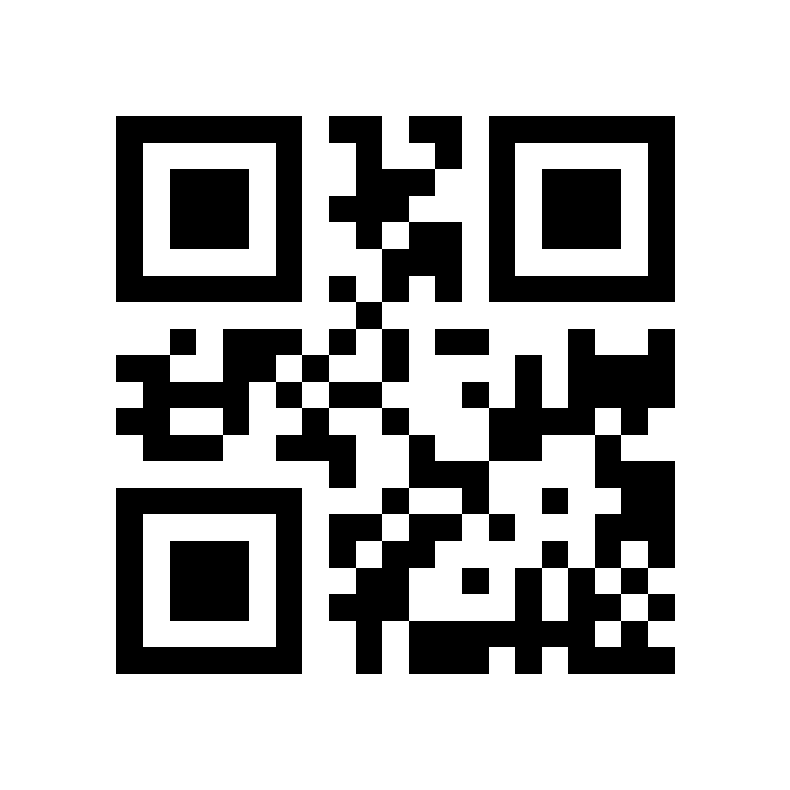

save hi /content/myQRcode.jpg


In [3]:
#!/usr/bin/env python3
# encoding: utf-8
import os
import cv2
import qrcode
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

def create_qrcode(data, file_name):
    '''
    버전: QR 코드의 크기를 제어하는 ​​1~40 값의 정수(최소값은 1, 12×12 행렬).
             프로그램이 이를 자동으로 결정하게 하려면 값을 없음으로 설정하고 맞춤 매개변수를 사용하십시오.
    error_correction: QR 코드의 오류 수정 기능을 제어합니다. 다음 4개의 상수를 사용할 수 있습니다.
    ERROR_CORRECT_L: 약 7% 이하의 오류를 수정할 수 있습니다.
    ERROR_CORRECT_M(기본값): 약 15% 이하의 오류를 수정할 수 있습니다.
    ROR_CORRECT_H: 약 30% 이하의 오류를 수정할 수 있습니다.
    box_size: QR 코드의 각 작은 격자에 포함된 픽셀 수를 제어합니다.
    border : 테두리(QR코드와 이미지 테두리 사이의 거리)에 포함되는 그리드의 개수를 조절합니다.
    '''
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=5,
        border=4)
    # 데이터 추가
    qr.add_data(data)

    qr.make(fit=True)
    # 이미지 생성
    img = qr.make_image(fill_color=(0, 0, 0), back_color=(255, 255, 255))
    opencv_img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    #cv2.imshow('img', opencv_img)
    #cv2.waitKey(0)
    #cv2.imwrite(file_name, opencv_img)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(opencv_img)
    plt.show()

    print('save', data, file_name)

if __name__ == '__main__':
    file_path = os.getcwd()
    out_img = file_path + '/myQRcode.jpg'
    qrcode_text = input("Please enter：")
    create_qrcode(qrcode_text, out_img)

In [4]:
import cv2

import numpy as np
from google.colab.output import eval_js
from base64 import b64decode
from base64 import b64encode

from IPython.display import display, Javascript
import PIL
import io


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


<IPython.core.display.Javascript object>

result: living room


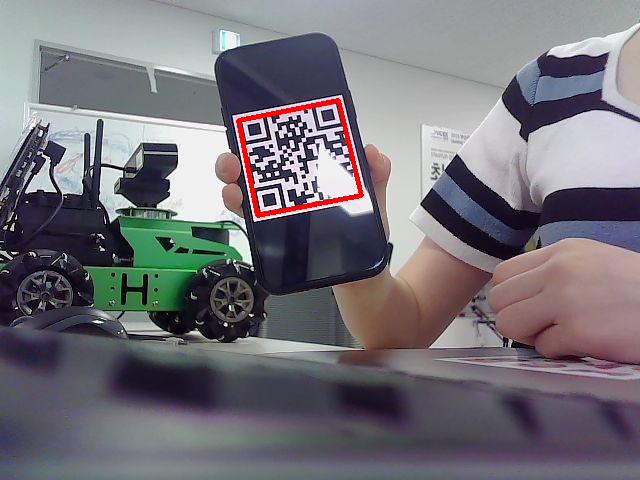

KeyboardInterrupt: ignored

In [16]:
from matplotlib.colors import Image
from google.colab.patches import cv2_imshow

import glob
import cv2
import pandas as pd
import pathlib


# MODEL_PATH = os.path.join(os.path.split(os.path.realpath(__file__))[0], 'opencv_3rdparty')
# model1 = os.path.join(MODEL_PATH, 'detect.prototxt')
# model2 = os.path.join(MODEL_PATH, 'detect.caffemodel')
# model3 = os.path.join(MODEL_PATH, 'sr.prototxt')
# model4 = os.path.join(MODEL_PATH, 'sr.caffemodel')

#detect_obj = cv2.wechat_qrcode_WeChatQRCode(model1, model2, model3, model4)

def read_qr_code(img):
    try:
        detect = cv2.QRCodeDetector()
        value, points, straight_qrcode = detect.detectAndDecode(img)
        return value, points
    except:
        return


def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def get_bbox(hand_landmarks, img):
    # Return normalized bounding box information (center, width, height) of the hand landmarks
    # Note: These are in relative coordinates
    if not hand_landmarks:
        return None
    x_min = min([landmark.x for landmark in hand_landmarks.landmark])
    x_max = max([landmark.x for landmark in hand_landmarks.landmark])
    y_min = min([landmark.y for landmark in hand_landmarks.landmark])
    y_max = max([landmark.y for landmark in hand_landmarks.landmark])
    center = [(x_min + x_max) / 2, (y_min + y_max) / 2]
    width = x_max - x_min
    height = y_max - y_min
    return img[int(center[1]*img.shape[0]):int((center[1]+height)*img.shape[0]), int(center[0]*img.shape[1]):int((center[0]+width)*img.shape[1])]

def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
            bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes



# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    #res, points = detect_obj.detectAndDecode(img)
    res, points = read_qr_code(img)
    if res != "":
      print('result:',res)
      for pos in points:
          color= (0, 0, 255)
          thick= 3
          for p in [(0, 1), (1, 2), (2, 3), (3, 0)]:
              start = int(pos[p[0]][0]), int(pos[p[0]][1])
              end = int(pos[p[1]][0]), int(pos[p[1]][1])
              cv2.line(img, start, end, color, thick)

      cv2_imshow(img)
    key = cv2.waitKey(1)
    if key != -1:
        break
    # Make detections
    #with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
      # Convert the BGR image to RGB before processing
    #  results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

      # Draw hand landmarks of each hand
    #  if results.multi_hand_landmarks:
    #    for hand_landmarks in results.multi_hand_landmarks:
    #        mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    #cv2_imshow(img)

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


In [ ]:
#!/usr/bin/env python3
# encoding: utf-8
import os
import cv2


MODEL_PATH = os.path.join(os.path.split(os.path.realpath(__file__))[0], 'opencv_3rdparty')
model1 = os.path.join(MODEL_PATH, 'detect.prototxt')
model2 = os.path.join(MODEL_PATH, 'detect.caffemodel')
model3 = os.path.join(MODEL_PATH, 'sr.prototxt')
model4 = os.path.join(MODEL_PATH, 'sr.caffemodel')

detect_obj = cv2.wechat_qrcode_WeChatQRCode(model1, model2, model3, model4)

cap = cv2.VideoCapture("/dev/astrapro")
#cap = cv2.VideoCapture("/dev/usb_cam")
print('\n******Press any key to exit!******')

while cap.isOpened():
    ret, img = cap.read()
    if ret:
        res, points = detect_obj.detectAndDecode(img)
        if res != ():
            print('result:',res)
        for pos in points:
            color= (0, 0, 255)
            thick= 3
            for p in [(0, 1), (1, 2), (2, 3), (3, 0)]:
                start = int(pos[p[0]][0]), int(pos[p[0]][1])
                end = int(pos[p[1]][0]), int(pos[p[1]][1])
                cv2.line(img, start, end, color, thick)
        fps.update()
        result_image = fps.show_fps(img)
        cv2.imshow('qrcode_detect', result_image)
        key = cv2.waitKey(1)
        if key != -1:
            break

cap.release()
cv2.destroyAllWindows()